In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [2]:
ds = xr.open_dataset('../data/processed/CESM2/Monthly_WBGT/monthly_wbgt_1231_ens1-5_1980-2100.nc')

In [3]:
ds = ds.isel(ensemble=0)

In [13]:
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__'].isel(ensemble=0).fillna(0)

In [10]:
ds = ds.rename({'__xarray_dataarray_variable__':'WBGT'})

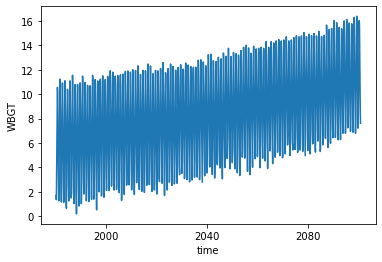

In [14]:
ds.weighted(land_area_cesm2).mean(['lat','lon'])['WBGT'].plot()

In [12]:
era_wbgt = xr.open_mfdataset('/local/ss23/ERA5/era5_daily_mean_WBGT*',concat_dim='time',combine='by_coords')
era_wbgt = era_wbgt.where(era_wbgt>25,25)
era_wbgt = era_wbgt.where(era_wbgt<33,33)

In [13]:
# Convert from WBGT to capacity
era_cap_daily = 100 - 25*((era_wbgt-25)**(2/3))

# Go from daily capacity to monthly capacity
era_cap_monthly = era_cap_daily.resample(time='1M').mean()

In [17]:
era_cap_monthly = era_cap_monthly.rename({'WBGT':'capacity'})

In [19]:
# Slice 1980-2000 data
ds = era_cap_monthly
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_mean = ds_hist.mean('year')
ds_hist_dev = ds_hist.std('year')

# Return baseline as the lower bound of "envelope" around mean 
ds_base = ds_hist_mean - 2*ds_hist_dev

In [25]:
ds_base = ds_base.rename({'longitude':'lon','latitude':'lat'})

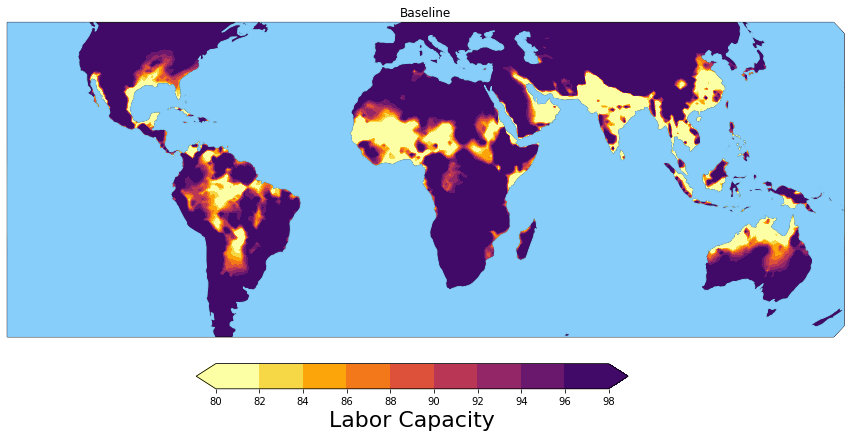

In [27]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(figsize=(15,7),subplot_kw={'projection':crs})
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
levels = np.arange(80,100,2)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,1,0.1))

im = lf.contour(ds_base,'Baseline',ax,levels=levels,cmap=None,colors=colors,over=None,crop=True)

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.125, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)

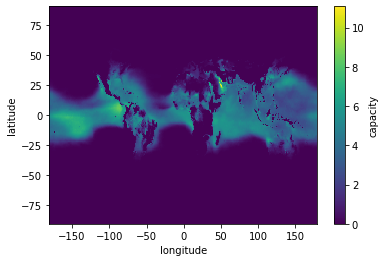

In [29]:
ds_hist_dev.plot()

In [ ]:
# Load WBT and temp data for ens3-30
wbt = xr.open_mfdataset('../data/processed/GFDL/WBT/*',combine='nested',concat_dim='ensemble',chunks={'time':1095})
t_ref = xr.open_mfdataset('/local/ss23/GFDL_LEs/ATM/RCP85/t_ref.rcp85.ens*.1950_2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})

# Calculate WBGT
wbgt = 0.7*wbt['WBT'] + 0.3*(t_ref['t_ref']-273.15)
wbgt_monthly = wbgt.resample(time='1M').mean()

# Save monthly WBGT for ens3-30
for index in range(0,27,3):
    ds = wbgt_monthly.isel(ensemble=slice(index,index+3))
    print(ds)

In [1]:
import xarray as xr

In [2]:
ds = xr.open_mfdataset('../data/processed/CESM2/TSAdailymean/*',combine='nested',concat_dim='ensemble',chunks={'time':1095})

In [3]:
ds

,Array,Chunk
Bytes,293.06 GB,242.20 MB
Shape,"(30, 44166, 192, 288)","(1, 1095, 192, 288)"
Count,3720 Tasks,1230 Chunks
Type,float32,numpy.ndarray
